In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt




loading images from folder C:/Users/Mark/Desktop/savio/deepCAL/comparison/VTB/


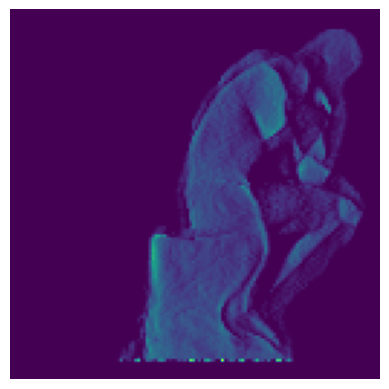

showing first loaded image
250
(360, 128, 128)
loading images from folder C:/Users/Mark/Desktop/savio/deepCAL/comparison/ML(new)/


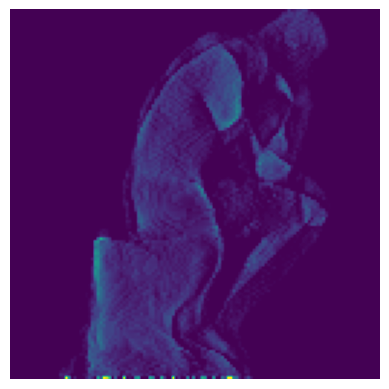

showing first loaded image
255
(360, 128, 128)
loading images from folder C:/Users/Mark/Desktop/savio/deepCAL/comparison/preProjectionSeq/


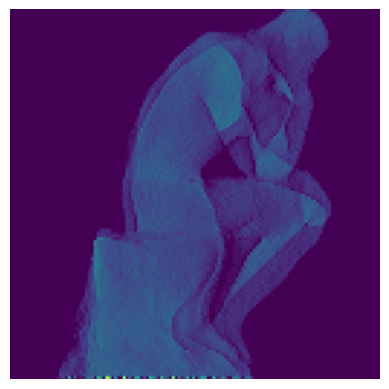

showing first loaded image
255
(360, 128, 128)


In [2]:
def load_png_to_numpy_array(folder_path, rotate=False):

    print(f"loading images from folder {folder_path}")

    image_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img = Image.open(os.path.join(folder_path, filename))
            image_list.append(np.array(img))



    images_array = np.array(image_list)

    if rotate:
        # Rotate every image in the array by 90 degrees
        rotated_images_array = np.array([np.rot90(img) for img in images_array])


    plt.imshow(rotated_images_array[0])
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()
    print("showing first loaded image")
    return rotated_images_array


# load ML projections
# projections_ML = load_png_to_numpy_array('C:/Users/Mark/Desktop/savio/deepCAL/ImageSeq', rotate=True)
projections_VTB = load_png_to_numpy_array('C:/Users/Mark/Desktop/savio/deepCAL/comparison/VTB/', rotate=True)
print(np.max(projections_VTB))
print(projections_VTB.shape)
assert projections_VTB.shape[1] == projections_VTB.shape[2] # make sure we are doing square imgs


projections_ML = load_png_to_numpy_array('C:/Users/Mark/Desktop/savio/deepCAL/comparison/ML(new)/', rotate=True)
print(np.max(projections_ML))
print(projections_ML.shape)
assert projections_ML.shape[1] == projections_ML.shape[2] # make sure we are doing square imgs

projections_NO_opt = load_png_to_numpy_array('C:/Users/Mark/Desktop/savio/deepCAL/comparison/preProjectionSeq/', rotate=True)
print(np.max(projections_NO_opt))
print(projections_NO_opt.shape)
assert projections_NO_opt.shape[1] == projections_NO_opt.shape[2] # make sure we are doing square imgs


In [3]:
import vamtoolbox as vam
from scipy.ndimage import zoom

def expand_3d_numpy_array(original_array, target_shape):
    

    # Assuming your original 3D array is called original_array with shape (115, 115, 128)
    original_shape = original_array.shape

    

    # Calculate the scaling factors for each dimension
    scaling_factors = (
        target_shape[0] / original_shape[0],
        target_shape[1] / original_shape[1],
        target_shape[2] / original_shape[2]
    )

    # Use the zoom function to interpolate the original array to the target shape
    interpolated_array = zoom(original_array, zoom=scaling_factors, order=1)
    return interpolated_array

def inverse_radon(projections, STLfile_name, resolution):
    num_angles = 360
    angles = np.linspace(0, 360 - 360 / num_angles, num_angles)
    proj_geo = vam.geometry.ProjectionGeometry(angles,ray_type='parallel',CUDA=True)
    target_geo = vam.geometry.TargetGeometry(stlfilename=STLfile_name, resolution=resolution)

    # Define the target shape (128, 128, 128)
    dims = projections.shape
    target_shape = (dims[1], dims[1], dims[2])
    target_geo.array = expand_3d_numpy_array(target_geo.array, target_shape)
    
    target_geo.nX = target_shape[0]
    target_geo.nY = target_shape[1]


    from vamtoolbox.projector.Projector3DParallelCUDA import Projector3DParallelCUDAAstra
    A = Projector3DParallelCUDAAstra(target_geo,proj_geo)
    tmp_projections = np.transpose(projections,(2,0,1))

    x = A.backward(tmp_projections)
    x = x/np.amax(x) # normalize

    # print(f"x shape : {x.shape}")

    # _error = vam.metrics.calcVER(target_geo,x)
    return x



c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


WE DO CAMPARISON HERE (above was just libraries)

In [4]:
# Generate the 3d voxels for ground truth and reconstruction

stl_file_name = "C:/Users/Mark/Desktop/savio/deepCAL/STLfiles/thinker_mod.stl"
resolution=projections_ML.shape[2]

reconstruction_ML = inverse_radon(projections=projections_ML, STLfile_name=stl_file_name, resolution=resolution)
reconstruction_NO_opt = inverse_radon(projections=projections_NO_opt, STLfile_name=stl_file_name, resolution=resolution)
reconstruction_VTB = inverse_radon(projections=projections_VTB, STLfile_name=stl_file_name, resolution=resolution)

ground_truth = vam.geometry.TargetGeometry(stlfilename=stl_file_name, resolution=resolution).array
ground_truth = expand_3d_numpy_array(ground_truth, reconstruction_ML.shape)
ground_truth = np.flip(ground_truth, axis=2)
# ground_truth = ground_truth[:][::-1]
# print(ground_truth.shape)


In [5]:
import vedo
# import gc
# gc.collect()

In [6]:
# display reocnstructed and ground truth voxels in 3d veiwer




def plot(data, d_l=0.1, d_h=1):
    vol = vedo.Volume(data).legosurface(vmin=d_l,vmax=d_h)
    vol.show(viewup="x")



In [7]:
d_l = 0.6
d_h = 0.85

def squared_difference(array1, array2):
    return (array1 - array2) ** 2

def MSE(array1, array2):
    squared_diff = squared_difference(array1, array2)
    mse = squared_diff.mean()
    return mse

def round_3d_array(array, round_down_threshold, round_up_threshold):
    rounded_array = [[[0 if value <= round_down_threshold else 1 if value >= round_up_threshold else 0.5 for value in row] for row in plane] for plane in array]
    return rounded_array

def L1_dif(array1, array2):
    # Calculate the L1 norm (sum of absolute differences)
    l1_norm = np.sum(np.abs(array1 - array2))
    return l1_norm

def count_above_dif_threshold(array1, array2, threshold):
    # Calculate absolute differences between the two arrays
    abs_diff = np.abs(array1 - array2)
    
    # Create a mask where values are above the threshold
    above_threshold_mask = abs_diff > threshold
    
    # Use the mask to filter the absolute differences and then sum them
    return np.sum(above_threshold_mask)


# dif = squared_difference(reconstruction_ML, ground_truth)

def compare(array1, array2):
    
    mse = MSE(array1, array2)
    l1 = L1_dif(array1, array2)

    threshold = 0.1
    count = count_above_dif_threshold(array1, array2, threshold)

    array2_descretized = np.array(round_3d_array(array2, round_down_threshold=d_l, round_up_threshold=d_h))

    solidified_voxel_differences = count_above_dif_threshold(array1, array2, threshold)

    # calcualte percentage eerors assuming array1 an darray2 have same number of voxels
    total_pixels = array1.shape[0] * array1.shape[1] * array1.shape[2]

    print(f"MSE: {mse}, L1: {l1}, % of different voxels above {threshold}: {count/total_pixels} solidified voxel difference to STL: {solidified_voxel_differences}")


    plot(array2_descretized, d_l=0.1, d_h=1)
    # plot(dif, d_l=0.1, d_h=1)


# compare(ground_truth, reconstruction_ML)


# PLOT THE NO OPTIMIZATION VOXELS
# NO_opt = round_3d_array(reconstruction_NO_opt, round_down_threshold=0.6, round_up_threshold=0.85)  
# plot(np.array(NO_opt), d_l=0.01, d_h=1)

# compare(ground_truth, reconstruction_NO_opt)


# PLOT THE VTB OPTIMIZATION VOXELS
# VTB_opt = round_3d_array(reconstruction_VTB, round_down_threshold=0.6, round_up_threshold=0.85)  
# plot(np.array(VTB_opt), d_l=0.01, d_h=1)

# compare(ground_truth, reconstruction_VTB)


# PLOT THE ML OPTIMIZATION VOXELS
# ML_opt = round_3d_array(reconstruction_ML, round_down_threshold=0.6, round_up_threshold=0.85)
# print(ML_opt[0][0])
# plot(np.array(ML_opt), d_l=0.01, d_h=1)

# compare(ground_truth, reconstruction_ML)



# plot(ground_truth)
# plot(dif, d_l=0.1, d_h=1)

# predicted_descretized = np.array(round_3d_array(predicted, round_down_threshold=d_l, round_up_threshold=d_h))
# solidified_voxel_differences = count_above_dif_threshold(ground_truth, predicted_descretized, 0.1)
# return solidified_voxel_differences

We calculate the optimal rotations for each optimization method below (set calculate_optimal_rotations = True)

checking 0 to 4
checking 0.6000000000000001 to 2.6
checking 0.9000000000000001 to 1.9000000000000001
checking 1.1500000000000001 to 1.6500000000000001
checking 1.3250000000000002 to 1.5750000000000002


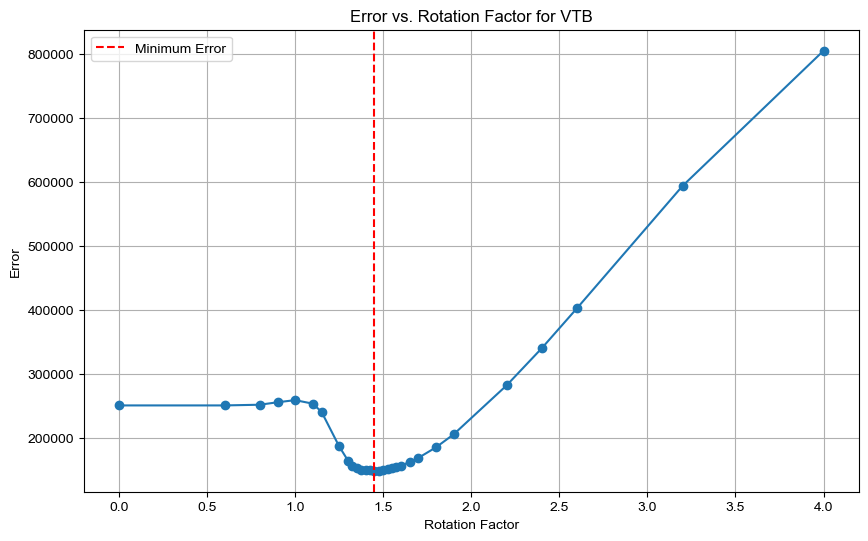

checking 0 to 4
checking -1.0 to 1.0
checking -0.5 to 0.5
checking -0.25 to 0.25
checking -0.125 to 0.125


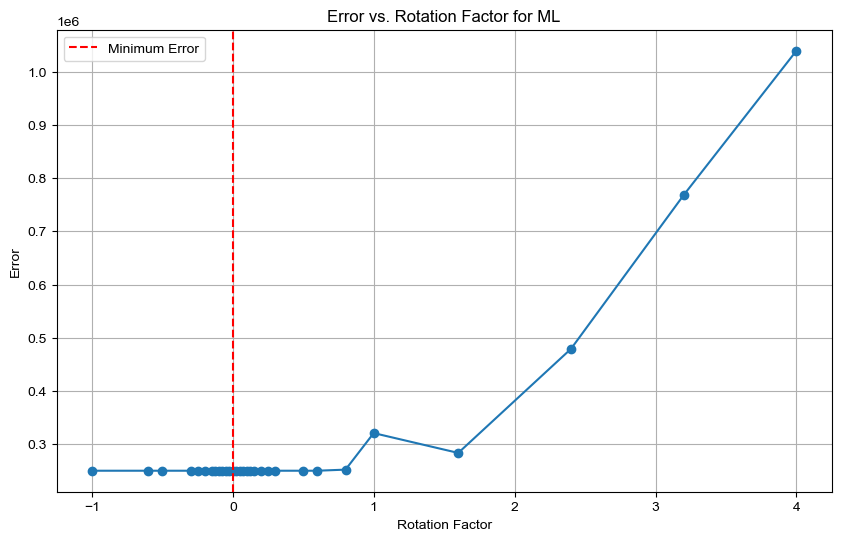

checking 0 to 4
checking -1.0 to 1.0
checking -0.5 to 0.5
checking -0.25 to 0.25
checking -0.125 to 0.125


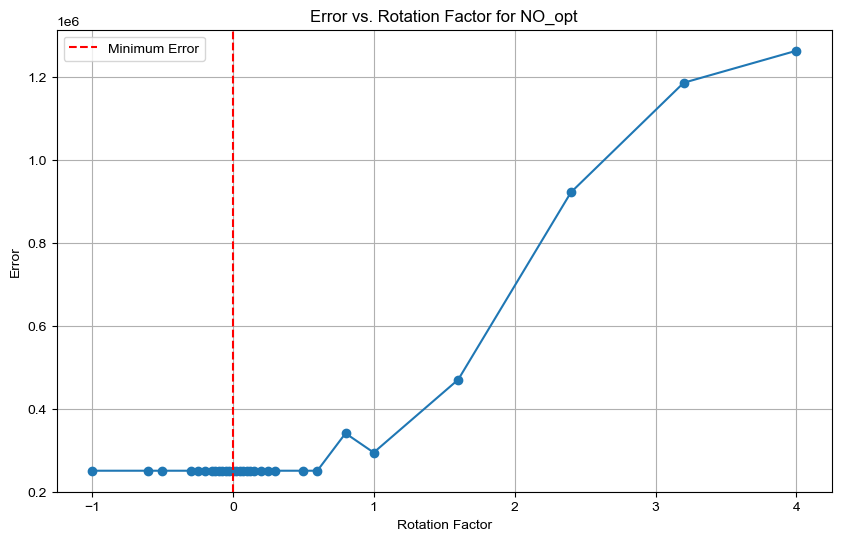

best number of rotations for VTB: 1.4500000000000002
best number of rotations for ML: 0.0
best number of rotations for no optimization: 0.0


In [8]:
calculate_optimal_rotations = True

if calculate_optimal_rotations:

    import matplotlib.pyplot as plt
    from tqdm import tqdm

    # def error_function(ground_truth, predicted):
    #     return MSE(ground_truth, predicted)

    def error_function(ground_truth, predicted):
        predicted_descretized = np.array(round_3d_array(predicted, round_down_threshold=d_l, round_up_threshold=d_h))
        solidified_voxel_differences = count_above_dif_threshold(ground_truth, predicted_descretized, 0.1)
        return solidified_voxel_differences

    def calculate_optimal_rotations(ground_truth, predicted, error_function, max_iterations=5, initial_range=[0, 4], resolution=6, name="undefined"):
        best_error = float('inf')
        best_rotations = 0
        error = []
        rotations_number = []

        for iteration in range(max_iterations):
            # Sample 'resolution' number of points in the interval 'initial_range'
            step_size = (initial_range[1] - initial_range[0]) / (resolution - 1)
            print(f"checking {initial_range[0]} to {initial_range[1]}")
            for i in range(resolution):
                temp = (initial_range[0] + i * step_size) * predicted
                error.append(error_function(ground_truth, temp))
                rotations_number.append((initial_range[0] + i * step_size))

            # Find the index of the minimum error in the current window
            min_error_idx = error.index(min(error))

            # Update the best error and rotations
            if error[min_error_idx] < best_error:
                best_error = error[min_error_idx]
                best_rotations = rotations_number[min_error_idx]

            # Update the search window for the next iteration
            # Ensure the range is centered around the minimum error point
            center = rotations_number[min_error_idx]
            width = (initial_range[1] - initial_range[0]) / 4
            initial_range = [center - width, center + width]

        # Create a figure and plot all data points
        sorted_lists = zip(rotations_number, error)
        sorted_lists = sorted(sorted_lists, key=lambda x: x[0])
        rotations_number, error = zip(*sorted_lists)
        plt.figure(figsize=(10, 6))
        plt.plot(rotations_number, error, marker='o')
        plt.title(f'Error vs. Rotation Factor for {name}')
        plt.xlabel('Rotation Factor')
        plt.ylabel('Error')
        plt.grid(True)

        plt.axvline(x=best_rotations, color='r', linestyle='--', label='Minimum Error')

        plt.legend()
        plt.show()

        return best_rotations

    opt_rotations_VTB = calculate_optimal_rotations(ground_truth, reconstruction_VTB, error_function, name="VTB", initial_range=[0, 4])
    opt_rotations_ML = calculate_optimal_rotations(ground_truth, reconstruction_ML, error_function, name="ML", initial_range=[0, 4])
    opt_rotations_NO_opt = calculate_optimal_rotations(ground_truth, reconstruction_NO_opt, error_function, name="NO_opt", initial_range=[0, 4])

    print(f"best number of rotations for VTB: {opt_rotations_VTB}")
    print(f"best number of rotations for ML: {opt_rotations_ML}")
    print(f"best number of rotations for no optimization: {opt_rotations_NO_opt}")


################################################################################################
# best number of rotations for VTB: 1.4500000000000002
# best number of rotations for ML: 1.6750000000000003
# best number of rotations for no optimization: 1.0250000000000001

In [9]:
best_number_of_rotation_NO_opt = 1.0250000000000001
best_number_of_rotation_VTB = 1.4500000000000002
best_number_of_rotation_ML = 1.6750000000000003

# NO_opt = round_3d_array(reconstruction_NO_opt * best_number_of_rotation_NO_opt, round_down_threshold=d_l, round_up_threshold=d_h)  
# plot(np.array(NO_opt), d_l=0.001, d_h=1)

# VTB_opt = round_3d_array(reconstruction_VTB * best_number_of_rotation_VTB, round_down_threshold=d_l, round_up_threshold=d_h)  
# plot(np.array(VTB_opt), d_l=0.001, d_h=1)

# ML_opt = round_3d_array(reconstruction_ML * best_number_of_rotation_ML, round_down_threshold=d_l, round_up_threshold=d_h)  
# plot(np.array(ML_opt), d_l=0.001, d_h=1)